In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from google.colab import drive
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
import pickle
import graphviz
from sklearn.tree import export_graphviz

データセット読み込み

In [2]:
df_original = pd.read_csv('drive/My Drive/data/application_train.csv')
df_test_original = pd.read_csv('drive/My Drive/data/application_test.csv') 

df = df_original
df_test = df_test_original

データチェック（307511サンプル×122カラム。typeはint,float,object）

In [3]:
print(df.head(4))
print(df.info())
print(df.describe())

   SK_ID_CURR  TARGET  ... AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_YEAR
0      100002       1  ...                       0.0                        1.0
1      100003       0  ...                       0.0                        0.0
2      100004       0  ...                       0.0                        0.0
3      100006       0  ...                       NaN                        NaN

[4 rows x 122 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
          SK_ID_CURR  ...  AMT_REQ_CREDIT_BUREAU_YEAR
count  307511.000000  ...               265992.000000
mean   278180.518577  ...                    1.899974
std    102790.175348  ...                    1.869295
min    100002.000000  ...                    0.000000
25%    189145.500000  ...                    0.000000
50%    278202.000000  ...              

テストデータチェック（48744サンプル×121カラム。typeはint,float,object）

In [4]:
print(df_test.head(4))
print(df_test.info())
print(df_test.describe())

   SK_ID_CURR  ... AMT_REQ_CREDIT_BUREAU_YEAR
0      100001  ...                        0.0
1      100005  ...                        3.0
2      100013  ...                        4.0
3      100028  ...                        3.0

[4 rows x 121 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None
          SK_ID_CURR  ...  AMT_REQ_CREDIT_BUREAU_YEAR
count   48744.000000  ...                42695.000000
mean   277796.676350  ...                    1.983769
std    103169.547296  ...                    1.838873
min    100001.000000  ...                    0.000000
25%    188557.750000  ...                    0.000000
50%    277549.000000  ...                    2.000000
75%    367555.500000  ...                    3.000000
max    456250.000000  ...                   17.000000

[8 rows x 105 columns]


目的変数（ターゲット）比率確認

In [5]:
n_target0, n_target1 = len(df[df['TARGET'] == 0]), len(df[df['TARGET'] == 1])
n_all = n_target0+n_target1
print('通常債務者(target:0)の割合 :' + '{:.2%}'.format(n_target0/n_all)) #target:0の割合
print('不良債務者(target:1)の割合 :' + '{:.2%}'.format(n_target1/n_all)) #target:1の割合

通常債務者(target:0)の割合 :91.93%
不良債務者(target:1)の割合 :8.07%


グルーピング

In [6]:
grouped = df.groupby('TARGET')
grouped[df.columns].mean()
#grouped['DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY'].mean()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
TARGET,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,278244.744536,0.0,0.412946,169077.722266,602648.282002,27163.623349,542736.795003,0.021021,-16138.176397,65696.146123,-5029.941065,-3017.219788,11.935540,0.999996,0.814653,0.195991,0.998129,0.284238,0.056840,2.150154,2.043578,2.022449,12.086807,0.014942,0.050317,0.040494,0.074641,0.22409,0.175856,0.511461,0.523479,0.520969,0.118314,0.088952,0.977893,0.753153,0.045005,0.080194,0.150249,0.228023,...,0.149735,0.227634,0.233097,0.067422,0.102582,0.109615,0.008687,0.028490,0.103507,1.415742,0.139148,1.398923,0.096688,-976.388294,0.000032,0.704060,0.000088,0.015126,0.090457,0.000198,0.082027,0.003976,0.000025,0.003990,0.000007,0.003729,0.003088,0.001277,0.010269,0.000283,0.008341,0.000605,0.000506,0.000315,0.006380,0.006914,0.034315,0.270697,0.265939,1.889199
1,277449.167936,1.0,0.463807,165611.760906,557778.527674,26481.744290,488972.412554,0.019131,-14884.828077,42394.675448,-4487.127009,-2732.099617,13.668691,1.000000,0.879517,0.237825,0.998187,0.244955,0.055347,2.181269,2.153635,2.134824,11.797100,0.017442,0.055911,0.042538,0.118389,0.30292,0.221672,0.386968,0.410935,0.390717,0.105766,0.081548,0.975634,0.743231,0.039444,0.062036,0.142707,0.203021,...,0.142227,0.202692,0.211754,0.063793,0.093478,0.095206,0.008171,0.024796,0.089769,1.496147,0.191980,1.477672,0.138247,-808.796818,0.000161,0.777925,0.000000,0.014985,0.060705,0.000121,0.073958,0.002981,0.000000,0.003021,0.000000,0.001208,0.001208,0.000443,0.006042,0.000081,0.005720,0.000483,0.000524,0.000564,0.006672,0.008036,0.034919,0.227926,0.259923,2.028783


In [7]:
#AMT_CREDIT, REG_REGION_NOT_WORK_REGION, DAYS_EMPLOYED, DAYS_REGISTRATION, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, EXT_SOURCE_2, DEF_30_CNT_SOCIAL_CIRCLE	

データ整理（欠損データ削除）

In [8]:
#print(df.isnull().sum()) #欠損率（欠損の発生しているカラムは少なく、またいずれも1%未満）
#print(df_test.isnull().sum() / len(df)) #欠損率（欠損の発生しているカラムは少なく、またいずれも1%未満）

df.dropna(thresh=304000, axis=1, inplace=True) #3000つ以上欠損値がある特徴量（列）の削除
df.dropna(how='any', axis=0, inplace=True) #欠損値があるサンプル（行）の削除

df_test['TARGET'] = '' #↓の処理の際にTARGETカラムが無いと処理できない為、追加
df_test = df_test[df.columns] #訓練データとカラムを合わせる
df_test = df_test.fillna(0) #欠損値には0を適用

相関関係ヒートマップ

In [9]:
df_corr = df.corr().abs() #相関関係のデータフレーム作成
df_corr.style.background_gradient(axis=None) #相関係数行列のヒートマップ

targetと相関関係の強いカラムを抽出

In [10]:
selected_cols = df_corr.nlargest(13,'TARGET')['TARGET'].index
print(selected_cols)

Index(['TARGET', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH',
       'REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'DAYS_EMPLOYED',
       'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION'],
      dtype='object')


前処理・訓練データと検証データの分割、標準化

In [11]:
X = df.select_dtypes(exclude=["object"]) #オブジックト列削除
#X = X.sample(10000)#サンプル数を10000へ絞り込み
X = X.drop('TARGET',axis=1).values # 説明変数(target以外の特徴量)

y = df['TARGET'] 
#y = y.sample(10000).values #サンプル数を10000へ絞り込み

t = df_test.select_dtypes(exclude=["object"]) #テストデータのオブジェクト列削除
t = t.values #ndarrayへ変換

#標準化
scaler = StandardScaler()
X = scaler.fit_transform(X)
t = scaler.fit_transform(t)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(t.shape)
print(type(y))

(213171, 53)
(213171,)
(48744, 53)
<class 'pandas.core.series.Series'>


スコア評価関数

In [12]:
def result(y_test_, Y_pred_):
  print(f'accuracy_score : {accuracy_score(y_test_, Y_pred_):.2%}')#正解率（正解の割合）
  print(f'precision_score : {precision_score(y_test_, Y_pred_):.2%}')#適合率（陽性と予測されたサンプルのうち正解したサンプルの割合）
  print(f'recall_score : {recall_score(y_test_, Y_pred_):.2%}.')#再現率（実際に陽性のサンプルのうち正解したサンプルの割合）
  print(f'f1_score : {f1_score(y_test_, Y_pred_):.2%}')#F値（適合率と再現率の調和平均）
  print('confusion_matrix :')#混同行列
  print(confusion_matrix(y_test_, Y_pred_))

  print(f'AUC : {roc_auc_score(y_test_, Y_pred_):.2%}')

  #ROC曲線描写
  fpr, tpr, thresholds = metrics.roc_curve(y_test_, Y_pred_)# FPR, TPR(, しきい値) を算出
  auc = metrics.auc(fpr, tpr) #auc

  plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
  plt.legend()
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)

決定木モデル

accuracy_score : 91.06%
precision_score : 16.63%
recall_score : 2.21%.
f1_score : 3.91%
confusion_matrix :
[[83028   832]
 [ 7334   166]]
AUC : 50.61%


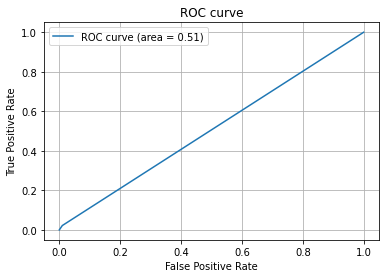

In [13]:
descision_tree = tree.DecisionTreeClassifier(random_state=0, min_samples_split=200)
model = descision_tree.fit(X_train, y_train) 
Y_pred = descision_tree.predict(X_test)
decision_tree = result(y_test, Y_pred)

In [50]:
dot_data = export_graphviz(model)

In [ ]:
graph_tree = graphviz.Source(dot_data)
graph_tree

In [38]:
feature_importance = model.feature_importances_
feature_importance

array([0.08665164, 0.0088971 , 0.04668057, 0.04542246, 0.0707746 ,
       0.042444  , 0.05205035, 0.08432479, 0.06620563, 0.08363978,
       0.07454345, 0.        , 0.00122947, 0.00728782, 0.        ,
       0.01021026, 0.00315122, 0.01540675, 0.00711256, 0.00530448,
       0.04320605, 0.00099173, 0.00221378, 0.00311494, 0.00324589,
       0.00633123, 0.00540576, 0.08797354, 0.01737485, 0.00757302,
       0.01986488, 0.00712252, 0.06439227, 0.        , 0.00558106,
       0.        , 0.00220666, 0.00108295, 0.        , 0.0039433 ,
       0.00107812, 0.        , 0.00072906, 0.        , 0.00062177,
       0.00126311, 0.        , 0.00166137, 0.        , 0.00137592,
       0.00030925, 0.        , 0.        ])

最近傍法

In [ ]:
##10-nn
knc_10nn = KNeighborsClassifier(n_neighbors=10)
knc_10nn.fit(X_train, y_train)
Y_pred = knc_10nn.predict(X_test)# 予測
result(y_test, Y_pred)

accuracy_score= 0.9076666666666666
precision_score= 0.0625
recall_score= 0.0038022813688212928
f1_score= 0.007168458781362006
confusion_matrix= 
[[2722   15]
 [ 262    1]]
AUC=0.49916091415901787


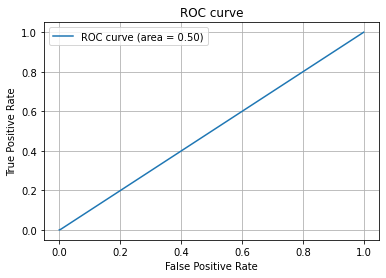

In [20]:
##5-nn
knc_5nn = KNeighborsClassifier(n_neighbors=5)
knc_5nn.fit(X_train, y_train)
Y_pred = knc_5nn.predict(X_test)# 予測　
result(y_test, Y_pred)

accuracy_score= 0.8423333333333334
precision_score= 0.06093189964157706
recall_score= 0.07456140350877193
f1_score= 0.0670611439842209
confusion_matrix= 
[[2510  262]
 [ 211   17]]
AUC=0.49002240449608864


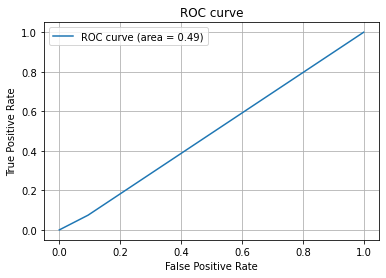

In [16]:
##1-nn
knc_nn1 = KNeighborsClassifier(n_neighbors=1)
knc_nn1.fit(X_train, y_train)
Y_pred = knc_nn1.predict(X_test)# 予測　
result(y_test, Y_pred)

ロジスティック回帰

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_score= 0.924
precision_score= 0.0
recall_score= 0.0
f1_score= 0.0
confusion_matrix= 
[[2772    0]
 [ 228    0]]
AUC=0.5


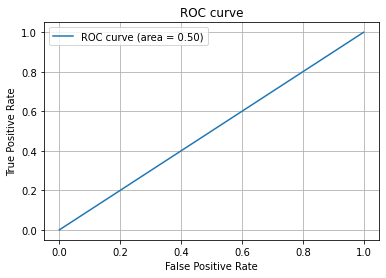

In [17]:
lr = LogisticRegression(random_state=0) # インスタンスを作成
lr.fit(X_train, y_train) # 学習
Y_pred = lr.predict(X_test)# 予測　
logistic_regression = result(y_test, Y_pred) #評価出力

SVM

accuracy_score= 0.924
precision_score= 0.0
recall_score= 0.0
f1_score= 0.0
confusion_matrix= 
[[2772    0]
 [ 228    0]]
AUC=0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


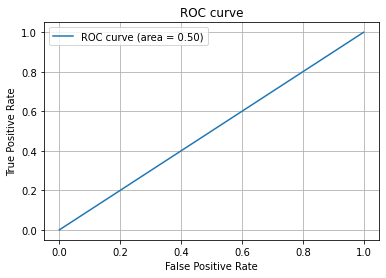

In [18]:
clf = SVC(random_state=0)#インスタンス作成
clf.fit(X_train, y_train) # 学習
Y_pred = clf.predict(X_test)# 予測　
svm = result(y_test, Y_pred) #評価出力

ランダムフォレスト

accuracy_score= 0.924
precision_score= 0.0
recall_score= 0.0
f1_score= 0.0
confusion_matrix= 
[[2772    0]
 [ 228    0]]
AUC=0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


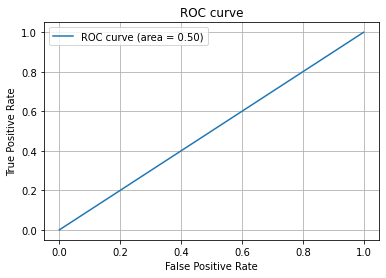

In [21]:
rfc = RandomForestClassifier(random_state=0)#インスタンス作成
rfc.fit(X_train, y_train) # 学習
Y_pred = rfc.predict(X_test)# 予測　
random_forest = result(y_test, Y_pred) #評価出力

LightGBM

accuracy_score= 0.9236666666666666
precision_score= 0.0
recall_score= 0.0
f1_score= 0.0
confusion_matrix= 
[[2771    1]
 [ 228    0]]
AUC=0.49981962481962483


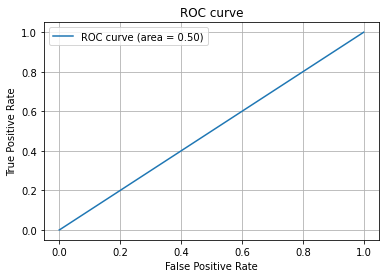

In [22]:
lgbm = lgb.LGBMClassifier(random_state=0) # モデルのインスタンスの作成
lgbm.fit(X_train, y_train) # モデルの学習
Y_pred = lgbm.predict(X_test)
lgbm = result(y_test, Y_pred) #評価出力

決定木手法を使用し、評価データ（テストデータ）へ適用

In [14]:
descision_tree = tree.DecisionTreeClassifier(random_state=0, min_samples_split=200)
descision_tree.fit(X_train, y_train) 
Y_pred = descision_tree.predict(t)

テストデータ整理（データ結合）、書き出し

In [23]:
df_test_pred = pd.DataFrame(Y_pred) #データフレームへ変換
df_test_pred = df_test_pred.rename(columns={0:'TARGET'}) #カラム名を'TARGET'へ変更
df_test_pred = pd.concat([df_test['SK_ID_CURR'], df_test_pred], axis=1) #データ結合

In [24]:
df_test_pred.to_csv('drive/My Drive/data/df_test_pred.csv', index=False) 

 **問題4**

データ初期化

In [442]:
df = df_original
df_test = df_test_original

欠損値削除

In [443]:
#print(df.isnull().sum()) #欠損率（欠損の発生しているカラムは少なく、またいずれも1%未満）
#print(df_test.isnull().sum() / len(df)) #欠損率（欠損の発生しているカラムは少なく、またいずれも1%未満）

df.dropna(thresh=304000, axis=1, inplace=True) #3000つ以上欠損値がある特徴量（列）の削除
df.dropna(how='any', axis=0, inplace=True) #欠損値があるサンプル（行）の削除

df_test['TARGET'] = '' #↓の処理の際にTARGETカラムが無いと処理できない為、追加
df_test = df_test[df.columns] #訓練データとカラムを合わせる
df_test = df_test.fillna(0) #欠損値には0を適用

特徴量エンジニアリング（one-hot-encording)

In [444]:
ohe_columns = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR']
df = pd.get_dummies(df, columns=ohe_columns) #訓練データ
df_test = pd.get_dummies(df_test, columns=ohe_columns) #テストデータ

In [445]:
df_corr = df[['TARGET', 'NAME_CONTRACT_TYPE_Cash loans', 'CODE_GENDER_M', 'FLAG_OWN_REALTY_Y', 'FLAG_OWN_CAR_Y']] .corr().abs() #相関関係のデータフレーム作成
df_corr.style.background_gradient(axis=None) #相関係数行列のヒートマップ

,TARGET,NAME_CONTRACT_TYPE_Cash loans,CODE_GENDER_M,FLAG_OWN_REALTY_Y,FLAG_OWN_CAR_Y
TARGET,1.000000,0.029920,0.055230,0.006742,0.021803
NAME_CONTRACT_TYPE_Cash loans,0.029920,1.000000,0.009222,0.066552,0.005920
CODE_GENDER_M,0.055230,0.009222,1.000000,0.044310,0.346372
FLAG_OWN_REALTY_Y,0.006742,0.066552,0.044310,1.000000,0.002165
FLAG_OWN_CAR_Y,0.021803,0.005920,0.346372,0.002165,1.000000


前処理

In [446]:
#性別、不動産所有有無、車所有有無を数値化し、収入・クレジット・年金・所有不動産価値と合わせたリスト
X = df[['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE']] 

#標準化
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = df['TARGET'].values # 目的変数(target)

t = df_test[['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y', 'EXT_SOURCE_2']] #カラム抽出
t = t.values #ndarrayへ変換

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(t.shape)
print(type(y))

(213171, 10)
(213171,)
(48744, 6)
<class 'numpy.ndarray'>


決定木

accuracy_score : 84.95%
precision_score : 12.90%
recall_score : 14.49%.
f1_score : 13.65%
confusion_matrix :
[[76519  7341]
 [ 6413  1087]]
AUC : 52.87%


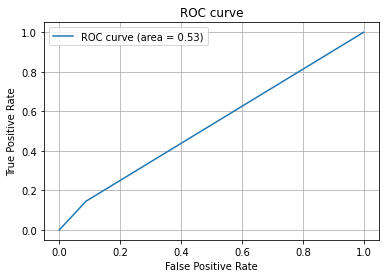

In [447]:
descision_tree = tree.DecisionTreeClassifier(random_state=0)#インスタンス作成
descision_tree.fit(X_train, y_train) # 学習
Y_pred = descision_tree.predict(X_test)# 予測　
decision_tree = result(y_test, Y_pred) #評価出力

kk

accuracy_score : 85.80%
precision_score : 12.94%
recall_score : 12.75%.
f1_score : 12.84%
confusion_matrix :
[[77430  6430]
 [ 6544   956]]
AUC : 52.54%


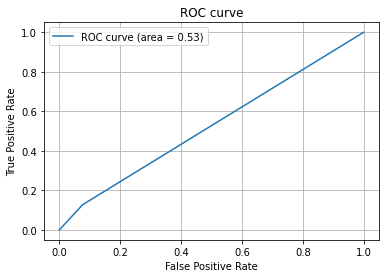

In [200]:
##1-nn
knc_nn1 = KNeighborsClassifier(n_neighbors=1)
knc_nn1.fit(X_train, y_train)
Y_pred = knc_nn1.predict(X_test)# 予測　
result(y_test, Y_pred)

ランダムフォレスト

accuracy_score : 91.73%
precision_score : 31.91%
recall_score : 0.60%.
f1_score : 1.18%
confusion_matrix :
[[83764    96]
 [ 7455    45]]
AUC : 50.24%


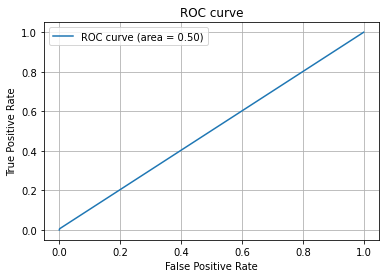

In [201]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
Y_pred = rfc.predict(X_test)
random_forest = result(y_test, Y_pred)

LightGBM

accuracy_score : 91.79%
precision_score : 0.00%
recall_score : 0.00%.
f1_score : 0.00%
confusion_matrix :
[[83860     0]
 [ 7500     0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC : 50.00%


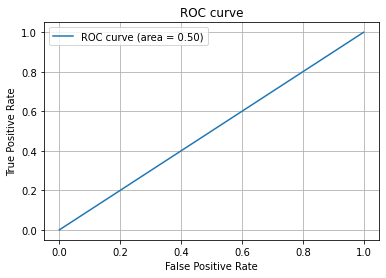

In [84]:
lgbm = lgb.LGBMClassifier(random_state=0) # モデルのインスタンスの作成
lgbm.fit(X_train, y_train) # モデルの学習
Y_pred = lgbm.predict(X_test)
lgbm = result(y_test, Y_pred) #評価出力

データ格納変数初期化

In [478]:
df = df_original
df_test = df_test_original

欠損値削除

In [479]:
#print(df.isnull().sum()) #欠損率（欠損の発生しているカラムは少なく、またいずれも1%未満）
#print(df_test.isnull().sum() / len(df)) #欠損率（欠損の発生しているカラムは少なく、またいずれも1%未満）

df.dropna(thresh=304000, axis=1, inplace=True) #3000つ以上欠損値がある特徴量（列）の削除
df.dropna(how='any', axis=0, inplace=True) #欠損値があるサンプル（行）の削除

df_test['TARGET'] = '' #↓の処理の際にTARGETカラムが無いと処理できない為、追加
df_test = df_test[df.columns] #訓練データとカラムを合わせる
df_test = df_test.fillna(0) #欠損値には0を適用

df.shape

(304531, 65)

オブジェクト型カラムの数値化、TARGETとの関係性調査

In [412]:
df_temp = df[['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']] #オブジェクト型

oe = OrdinalEncoder()
oe.fit(df_temp)
X = oe.transform(df_temp)

#目的変数加工
y = df['TARGET'].values
y = y.reshape(304531,1)

#データのマージ
df_marged = np.concatenate([X, y], 1)
df_marged = pd.DataFrame(df_marged)
df_marged = df_marged.set_axis(['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE','TARGET'], axis='columns')

#相関関係図化
df_marged_corr = df_marged.corr().abs() 
df_marged_corr.style.background_gradient(axis=None) 

,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,TARGET
NAME_TYPE_SUITE,1.000000,0.007618,0.036179,0.042076,0.032326,0.007996,0.029766,0.008503
NAME_INCOME_TYPE,0.007618,1.000000,0.087980,0.050606,0.035851,0.001824,0.177043,0.046882
NAME_EDUCATION_TYPE,0.036179,0.087980,1.000000,0.004578,0.016890,0.004054,0.092615,0.054492
NAME_FAMILY_STATUS,0.042076,0.050606,0.004578,1.000000,0.063056,0.000286,0.086658,0.000168
NAME_HOUSING_TYPE,0.032326,0.035851,0.016890,0.063056,1.000000,0.001125,0.069109,0.034673
WEEKDAY_APPR_PROCESS_START,0.007996,0.001824,0.004054,0.000286,0.001125,1.000000,0.002605,0.004094
ORGANIZATION_TYPE,0.029766,0.177043,0.092615,0.086658,0.069109,0.002605,1.000000,0.031101
TARGET,0.008503,0.046882,0.054492,0.000168,0.034673,0.004094,0.031101,1.000000


特徴量エンジニアリング（OrdinalEncoder）

In [481]:
ohe_columns = ['CODE_GENDER']
df_temp_2 = pd.get_dummies(df, columns=ohe_columns) #訓練データ
df_test = pd.get_dummies(df_test, columns=ohe_columns) #テストデータ
df_temp_2 = df_temp_2['CODE_GENDER_M']

In [482]:
df_temp_3 = df[['EXT_SOURCE_2', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH','REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'DAYS_EMPLOYED','REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION']]

In [483]:
df_temp_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304531 entries, 0 to 307510
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   CODE_GENDER_M  304531 non-null  uint8
dtypes: uint8(1)
memory usage: 2.6 MB


In [494]:
X = pd.concat([df_temp_2, df_temp_3], axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df['TARGET'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(t.shape)

(213171, 13)
(213171,)
(48744, 6)


決定木

accuracy_score : 84.81%
precision_score : 12.62%
recall_score : 14.35%.
f1_score : 13.43%
confusion_matrix :
[[76408  7452]
 [ 6424  1076]]
AUC : 52.73%


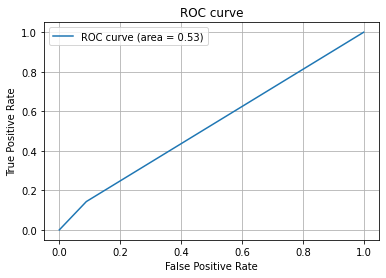

In [506]:
descision_tree = tree.DecisionTreeClassifier(random_state=0)#インスタンス作成
descision_tree.fit(X_train, y_train) # 学習
Y_pred = descision_tree.predict(X_test)# 予測　
decision_tree = result(y_test, Y_pred) #評価出力

ランダムフォレスト

accuracy_score : 91.78%
precision_score : 40.32%
recall_score : 0.33%.
f1_score : 0.66%
confusion_matrix :
[[83823    37]
 [ 7475    25]]
AUC : 50.14%


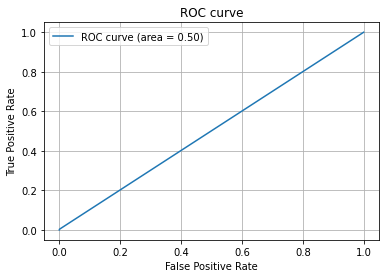

In [507]:
rfc = RandomForestClassifier(random_state=0)#インスタンス作成
rfc.fit(X_train, y_train) # 学習
Y_pred = rfc.predict(X_test)# 予測　
random_forest = result(y_test, Y_pred) #評価出力

In [ ]:
clf = SVC(random_state=0)#インスタンス作成
clf.fit(X_train, y_train) # 学習
Y_pred = clf.predict(X_test)# 予測　
svm = result(y_test, Y_pred) #評価出力

LightGBM

accuracy_score : 91.79%
precision_score : 0.00%
recall_score : 0.00%.
f1_score : 0.00%
confusion_matrix :
[[83860     0]
 [ 7500     0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC : 50.00%


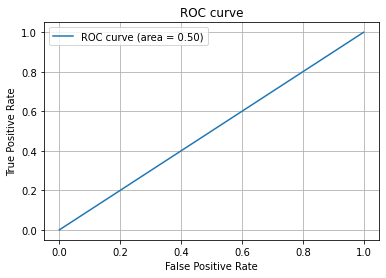

In [266]:
lgbm = lgb.LGBMClassifier(random_state=0) # モデルのインスタンスの作成
lgbm.fit(X_train, y_train) # モデルの学習
Y_pred = lgbm.predict(X_test)
lgbm = result(y_test, Y_pred) #評価出力

※どの特徴量を使うか：　EXT_SOURCE_2', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH','REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'DAYS_EMPLOYED','REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION,CODE_GENDER

※どう前処理をするか：OrdinalEncoderとHotOneEncoderを使い、カテゴリ変数を数値化